# Part 2: Time Series Forecast with ARIMA (2 days) 📈

Welcome to the second part of your journey towards mastering the art of forecasting with ARIMA models. We will demystify ARIMA models, beginning with its foundational principles - autoregression, differencing, moving average. Using the same dataset as in Part 1, you will fit different models and assess their quality in order to compare them. You will also learn the different way of performing train/test splits and cross-validation in the context of time series!

In this notebook, we will cover the following concepts:
- Train / Test splitting for time series
- Naive forecasting models
- ARIMA and SARIMA models
- Cross-Validation for time series

**Objectives**
- Get to use few prediction models
- Understand Cross-Validation in the context of Time Series

**Ressources**

AR, MA, ARIMA :

- https://www.youtube.com/watch?v=Mc6sBAUdDP4&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=6
- https://www.youtube.com/watch?v=zNLG8tsA_Go&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=6
- https://www.youtube.com/watch?v=dXND1OEBABI&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=7

ACF & PACF :

- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Métriques :

- https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

Cross-validation :

- https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
- https://robjhyndman.com/hyndsight/tscv/

Forecasting: Principles and Practice livre (Rob Hyndman) :

- https://otexts.com/fpp2/
- https://otexts.com/fpp2/non-seasonal-arima.html
- https://otexts.com/fpp2/transformations.html
- https://otexts.com/fpp2/seasonal-arima.html

Documentation de Pmdarima:

- http://alkaline-ml.com/pmdarima/


**Required librairies**
- [ ] numpy
- [ ] pandas
- [ ] matplotlib
- [ ] seaborn
- [ ] pmdarima
- [ ] sktime

In [1]:
%pip install sktime
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import sktime as sk

Note: you may need to restart the kernel to use updated packages.


# A bit of theory, again 😁

The ARMA (AutoRegressive Moving Average) model is suitable for predicting any time series whose value $Y$ at time $t$ can be explained by previous values and previous perturbations (noise).

Before specifying what a dataset is according to the ARIMA model, let's specify a dataset according to the conditions :  

- **Autoregressive**: the model predicts the variable $Y$ at time $t$, denoted $Y_t$, from previous values of $Y$ according to a linear regression model, i.e. $Y_{t-1}, Y_{t-2}, ..., Y_0$. Let $p$ denote the number of components used to predict $Y_t$, with

> $Y_t = \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + c$, with $\varepsilon_t$ a perturbation, and c a constant.

- **Moving average**: a model where the data are the result of the moving average of order $q$. The value $Y_t$ can be expressed using the perturbation at time $t$ and its previous values:

> $Y_t = \mu + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t-q}$, with $\mu$ a constant.

Any ARMA model is the combination of the *AR* and *MA* conditions, i.e. it is autoregressive and its noise follows a moving average. Let :

> $Y_t = c + \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t_q}$

or :

> $Y_t - \sum_{i=1}^p \varphi_i Y_{t-i} = \varepsilon_t + \sum_{i=1}^q \theta_i \varepsilon_{t-i}$ with $\varepsilon_t$ the error of the autoregressive model at time $t$.

The model is optimized using the least-squares method.

An ARMA model is suitable for stationary data sets, i.e. with a fixed mean and standard deviation over time. Such data are rarely observed. Many time series datasets show trends in the mean or seasonal patterns. To do this, the problem must first be stationarized. As we saw before, this can be done by differencing the data, apply a model, and then performing the reverse operation: **integration**. An **ARIMA** model is said to be :

- **integrated**: when the data set can be corrected by running the model on $Y'_t = Y_t - Y_{t-1}$ for a correction of order 1 (d=1), or $Y''_t = Y_t - Y_{t-1} - Y_{t-2}$ for a correction of order 2 (d=2), etc...  We note $d$ the order of *correction by integration* to suppress polynomial tendencies of order $d$, with:
    
> $Ycorr_t = Y_t - \sum_{1}^{d} Y_{t-d}$


ARIMA models are often denoted: ARIMA(p, d, q), or **ARIMA(2, 1, 1)** means :
- an autoregressive model of order 2,
- on data integrated 1 times,
- with a moving average of order 1.

# 1. Train / Test Splitting

Because the temporal order is important in time series, we cannot perform a random train/test split. Rather, we can use the most recent data (e.g. the last year) as the test set!

**TODO**
- Explain why train/test splitting can be a challenge for time series
- Write a function to split the dataset into a train and test set
- Use the function to split the airline passengers dataset, keeping the last twelve months as a test set
- Plot the train and test set in different colors

In [2]:
from sktime.datasets import load_airline

# Load dataset
airline = load_airline()

# Clean & Adjust the data
airline = airline.dropna()
airline_adj = airline / airline.index.days_in_month

In [3]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    
    # Your code here
    train = data[data.index < split_date]
    test = data[data.index >= split_date]
    
    return train, test


Training data size: 115
Test data size: 29


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

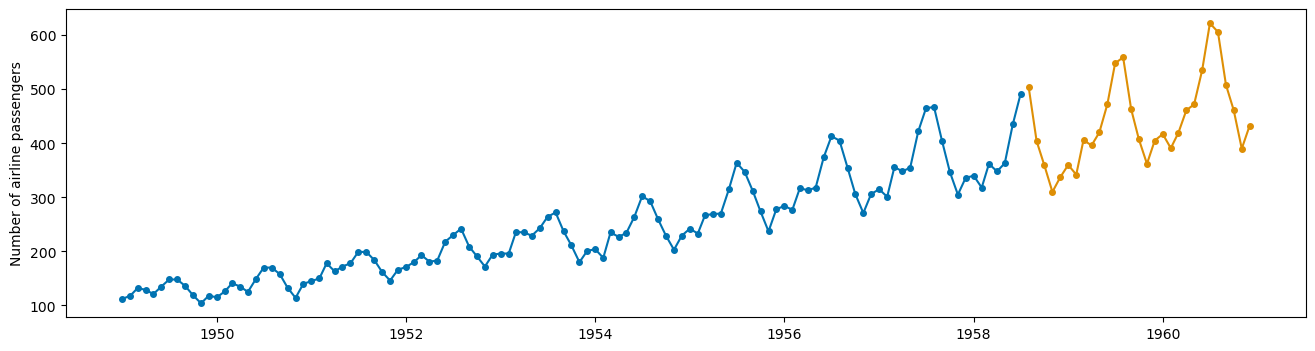

In [4]:
from sktime.utils.plotting import plot_series

# Hold back the last three years as a TEST set
split_date = airline.index[int(len(airline) * 0.8)]
train, test = ts_train_test_split(airline, split_date)

# Check train and test sizes are what we expect
print(f"Training data size: {len(train)}")
print(f"Test data size: {len(test)}")

# Plot the series
plot_series(train, test)



# 2. Naive Forecast

We need a baseline (as always!) to know if our more complex models are any use! Given the strong seasonal component that was confirmed by the seasonal decomposition we made earlier, it may be a good idea to use a **seasonal naive** forecasting method. This model takes the value from the same period in the previous season (in this case the same month last year). This is part of the Carry-Forward-Previous-Values' family of **naive** forecasting methods. In general, if we have data with period $k$ are at time $t$ and we are predicting time $Y_{t+1}$ then we simply carry forward the value from $Y_{t+1-k}$. In other words, we have yearly data so we just take the value from the same month last year.

In [5]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

HORIZON = 12  # We plan to make forecasts for the following 12 months
PERIOD = 12  # Expected period of seasonality

# Define the length of time into the future for which forecasts are to be prepared
fh = ForecastingHorizon(test.index, is_relative=False)

### 2.1 Fit a Naive Forecaster

**TODO**
- Fit a Naive and Seasonal Naive forecaster to the train data, and show the predictions along with the test data.
- Plot the residuals using Seaborn's `displot()`, `regplot()` and `residplot()` functions.

In [6]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

# Forecasting horizon (ex: 12 pas de temps à prédire)
fh = ForecastingHorizon(test.index, is_relative=False)

# Naive Forecaster
naive_forecaster = NaiveForecaster(strategy="last")
naive_forecaster.fit(train)
pred_naive = naive_forecaster.predict(fh)

# Seasonal Naive Forecaster
seasonal_naive_forecaster = NaiveForecaster(strategy="last", sp=12)  # sp = saisonnalité
seasonal_naive_forecaster.fit(train)
pred_seasonal = seasonal_naive_forecaster.predict(fh)


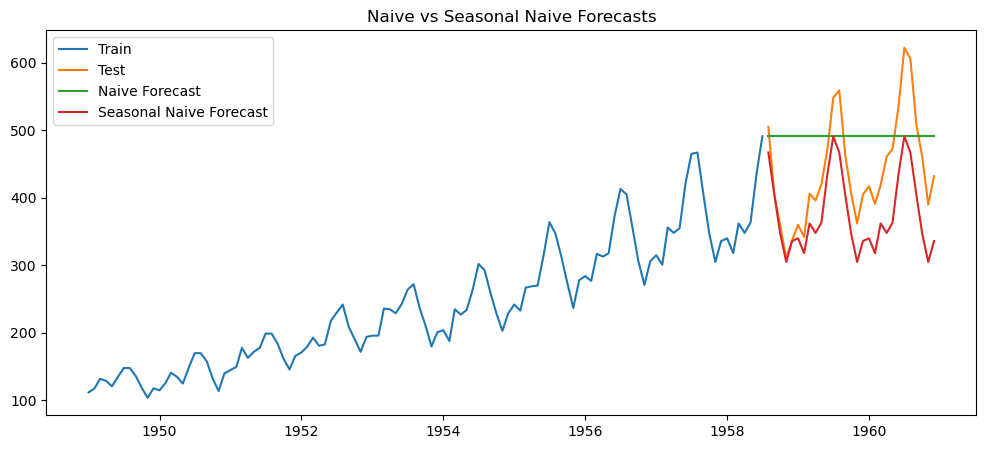

In [7]:
# Your code for the Seasonal Naive Forecaster
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train.index.to_timestamp(), train.values, label="Train")
plt.plot(test.index.to_timestamp(), test.values, label="Test")
plt.plot(test.index.to_timestamp(), pred_naive.values, label="Naive Forecast")
plt.plot(test.index.to_timestamp(), pred_seasonal.values, label="Seasonal Naive Forecast")
plt.legend()
plt.title("Naive vs Seasonal Naive Forecasts")
plt.show()


Plotting the **residuals** can give us information about how the model is performing and the errors it is making.  Sometimes there are reffered to as **in sample** diagnostics. This just means we are looking at diagnostics of data which has been used to fit the model. 

In [8]:
residuals_naive = test - pred_naive
residuals_seasonal = test - pred_seasonal

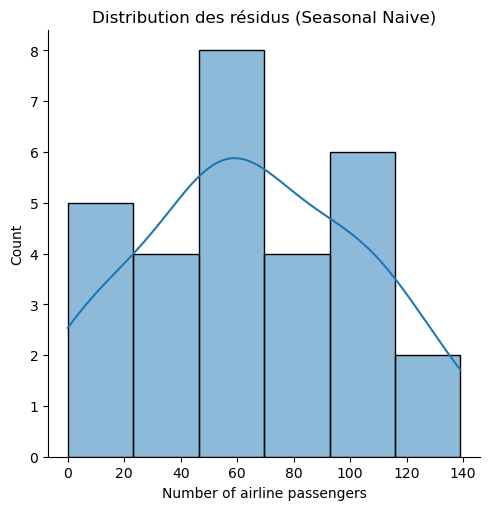

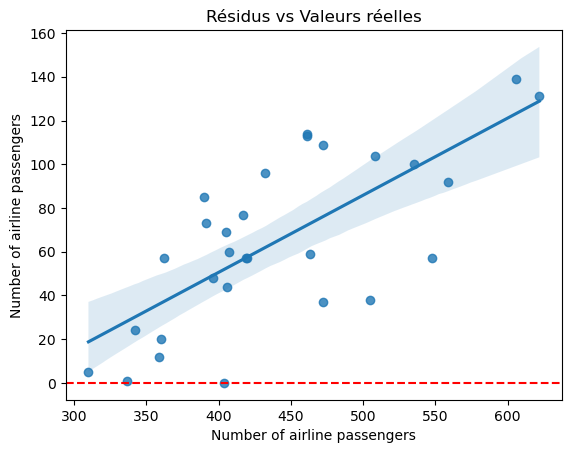

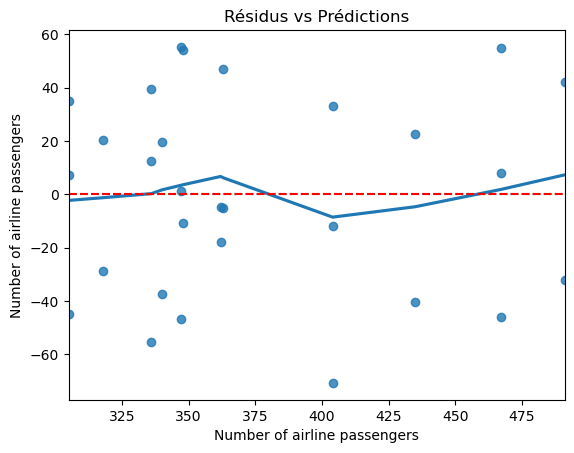

In [9]:
import seaborn as sns

# displot
sns.displot(residuals_seasonal, kde=True)
plt.title("Distribution des résidus (Seasonal Naive)")
plt.show()

# regplot (valeurs réelles vs résidus)
sns.regplot(x=test, y=residuals_seasonal)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs Valeurs réelles")
plt.show()

# residplot (prédictions vs résidus)
sns.residplot(x=pred_seasonal, y=residuals_seasonal, lowess=True)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs Prédictions")
plt.show()


### 2.2 Error Metrics

You've probably already worked with the Mean Squared Error (MSE). Let's have a look at different metrics.

RMSE and MAE are called 'scale dependent' measures as the units and magnitude are specific to the problem and context.  An alternative approach is to use a scale invariant measure such as the **mean absolute percentage error (MAPE)**

The percentage error is given by $p_t = 100e_t/y_t$ where $e_t$ is the error in predicting $y_t$.  Therefore, MAPE = $mean(|p_t|)$. A limitation of MAPE is that it is inflated when the denominator is small relative to the absolute forecast error (such in the case of outliers or extreme unexpected events). It also penalises negative errors more than positive errors.  A consequence of this property is that MAPE can lead to selecting a model that tends to under forecast.  The two following examples illustrate the issue. $$APE_{1} = \left| \frac{y_t - \hat{y_t}}{y_t} \right|= \left| \frac{150 - 100}{150} \right| = \frac{50}{150} = 33.33\%$$  

$$APE_{2} = \left| \frac{100 - 150}{100} \right| = \frac{50}{100} = 50\%$$

**TODO**
- Write a function to compute the MAPE
- Calculate the in-sample RMSE and MAPE for the last twelve months

In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    
    # Your code here
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Éviter la division par zéro
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [11]:
# Your code calculating the RMSE and MAPE for the Naive and Seasonal Naive models
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [12]:
from sklearn.metrics import mean_squared_error

# Prédictions sur les 12 derniers mois du train
fh_insample = ForecastingHorizon(train.index[-12:], is_relative=False)
insample_preds = seasonal_naive_forecaster.predict(fh_insample)

# Vraies valeurs correspondantes
insample_true = train.loc[train.index[-12:]]

# Calcul des métriques
rmse_val = rmse(insample_true, insample_preds)
mape_val = mean_absolute_percentage_error(insample_true, insample_preds)

print(f"🔍 In-sample diagnostics (last 12 months of train):")
print(f"RMSE : {rmse_val:.2f}")
print(f"MAPE : {mape_val:.2f}%")


🔍 In-sample diagnostics (last 12 months of train):
RMSE : 31.41
MAPE : 6.85%


# 3. ARIMA Forecast

Let's try an ARIMA model at last. Using a classical statsitical approach you would select the order of model which produces a model with acceptable residual plots (remember the first part of linear regression module?). Selecting the best model can also be done automatically using packages which do it for you! Wohoo! 🎉

The `pmdarima` package is an excellent forecasting library for building ARIMA models.  I recommend it over the options available in the core `statsmodels` package.  It is easier to use and offers an `auto_arima()` function that iteratively searches for a model that minimises the **Akaike Information Criterion (AIC)**

* ${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$

where $k$ = number of parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model.  A likelihood function measures the 'goodness' of fit of a model to data given a set of parameters.  

This looks very complicated at first, but all we need to remember is that the models we are working with are very flexible. This means that we can easily create complex models that overfit. Recall that overfitting is when a model will predict the training data exceptionally well, but will perform poorly on out of sample data.  The form of AIC means that it rewards models that fit the training data well, but also penalises models with high $k$ (complicated models with lots of parameters).  That means that AIC will prefer simpler models - in turn reducing overfitting.  That's a great formula for automatically selecting a good ARIMA forecasting model.

Even though modern applications tend to opt for the automatic approach for selecting the ARIMA parameters, we will have a go a trying and comparing how we perform with manual selection. As we discussed above, to train an ARIMA($p$,$d$,$q$) model we need to specify three parameters: $p$ (*AR*), $d$ (*I*) and $q$ (*MA*):
- To determine $p$, we look at the *direct* correlations, i.e. the *PACF*, and search for the lag $i$ such that $PACF_i \approx 0$
- To determine $q$, we look at the *full* correlations, i.e. the *ACF*, and search for the lag $i$ such that $ACF_i \approx 0$

Sometimes, we cannot apply directly these guidelines, and we must rely on a more detailed analysis or a grid search to determine the best $p,q$ for the problem at hand.

### Load the dataset & transform it

ARIMA models can take into account an increasing mean over time, but not the variance. Thus, a log transformation is enough for our purposes!

In [13]:
# Reload dataset from pmdarima
from pmdarima.datasets import load_airpassengers
from pmdarima.utils import acf, pacf
from pmdarima import ARIMA

# Load dataset
START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

# There's no DateTimeIndex from the bundled dataset. So let's add one.
airline.index = pd.date_range(START_DATE, periods=len(airline), freq='MS')

# Clean & Adjust data
airline_adj = airline / airline.index.days_in_month

# Train / Test split
train, test = ts_train_test_split(airline_adj, '1960-01-01')

# Apply log transformation
train_log = np.log(train).dropna()
test_log = np.log(test).dropna()

### 3.1 Estimate $p$, $d$ and $q$

**TODO**
- Based on the analysis done on the previous notebook, what would be a plausible value for $d$ ?
- Plot the ACF and PACF and determine some plausible values for $p$ and $q$.
- Fit the ARIMA model and show the diagnostics using the `plot_diagnostics()` of pmdarima. Describe the different plots. How do you interpret these results ?

In [14]:
# Your code for the ACF & PACF plots
from statsmodels.tsa.stattools import adfuller

# Test de stationnarité (ADF) sur la série log-transformée
result = adfuller(train_log)
print(f"p-value : {result[1]:.4f}")



p-value : 0.6686


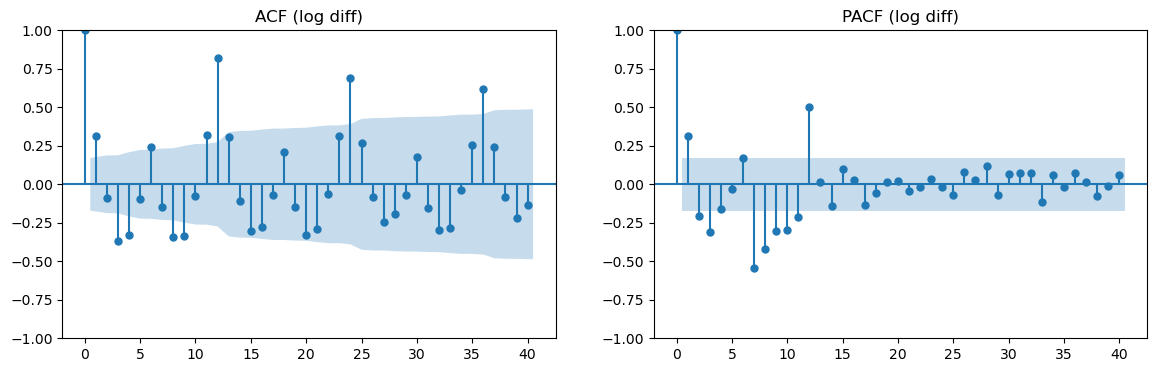

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# 1ère différence après log
train_log_diff = train_log.diff().dropna()

# ACF / PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train_log_diff, lags=40, ax=axes[0])
axes[0].set_title("ACF (log diff)")
plot_pacf(train_log_diff, lags=40, ax=axes[1])
axes[1].set_title("PACF (log diff)")
plt.show()


In [16]:
# Your code for the ARIMA model
from pmdarima.arima import ARIMA

# Fit du modèle ARIMA(p,d,q)
model = ARIMA(order=(2, 1, 2))
model.fit(train_log)



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(2, 1, 2))

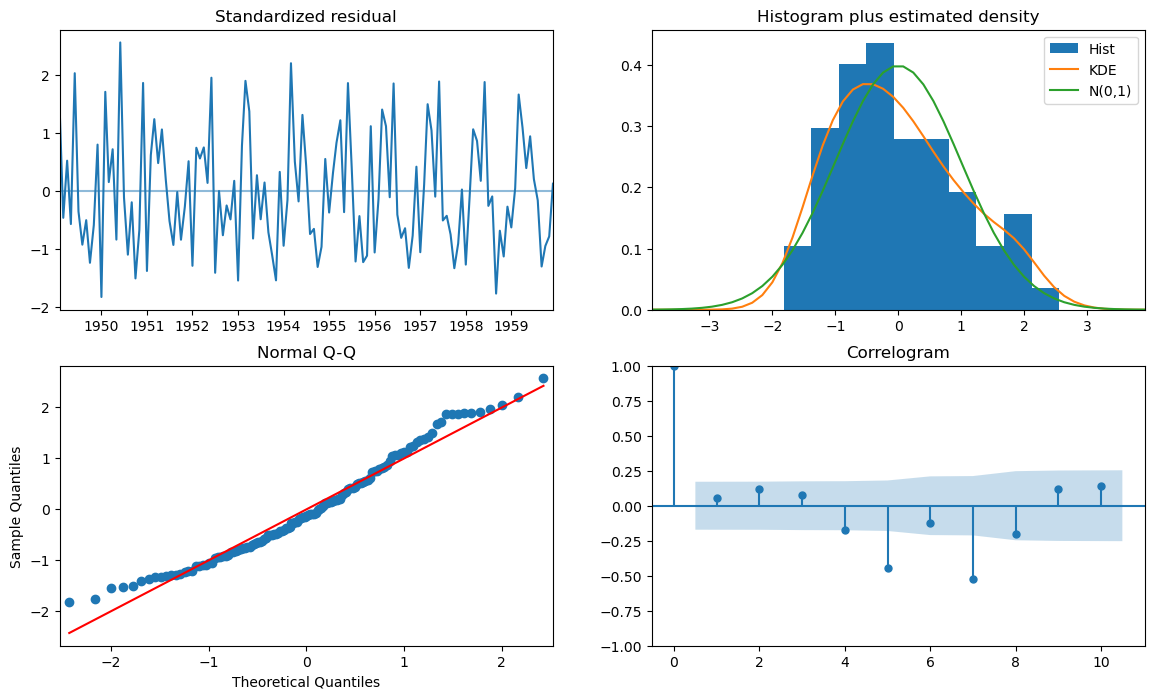

In [17]:
model.plot_diagnostics(figsize=(14, 8))
plt.show()


**TODO**
- Make a figure showing the train set, the test set, the predictions from ARIMA and the confidence intervals
- Make a second figure showing the predictions for the next 100 periods
- Calculate the RMSE and the MAPE on the test set

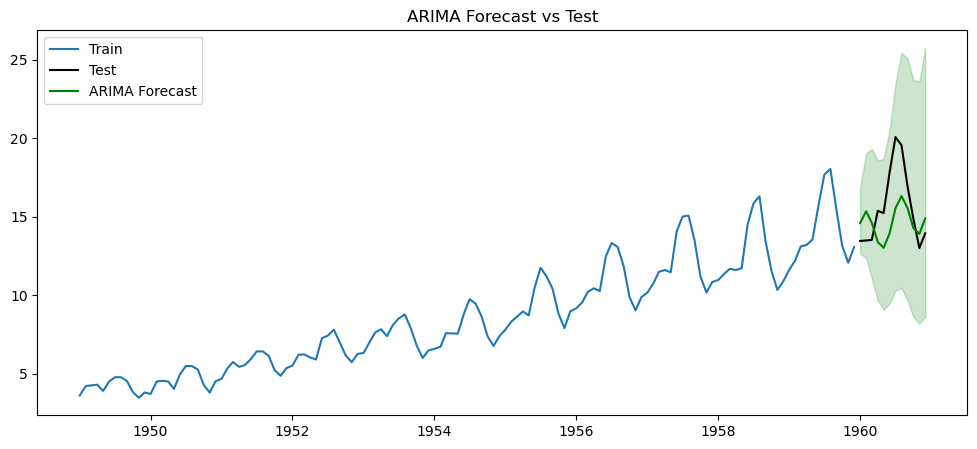

In [18]:
# Your code showing train, test, predictions and confidence interval
# Prédiction sur la période test
n_periods = len(test_log)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Re-transformer les données en échelle réelle (exp)
forecast_exp = np.exp(forecast)
conf_int_exp = np.exp(conf_int)

plt.figure(figsize=(12, 5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color='black')
plt.plot(test.index, forecast_exp, label="ARIMA Forecast", color='green')
plt.fill_between(test.index, conf_int_exp[:, 0], conf_int_exp[:, 1], color='green', alpha=0.2)
plt.title("ARIMA Forecast vs Test")
plt.legend()
plt.show()

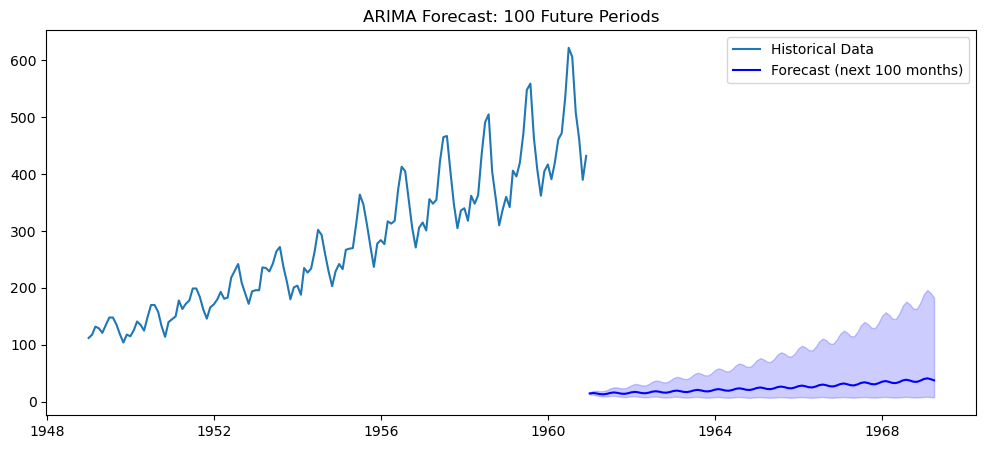

In [19]:
# Your code for showing the predictions for 100 periods

future_forecast, future_conf = model.predict(n_periods=100, return_conf_int=True)
future_index = pd.date_range(test.index[-1] + pd.DateOffset(months=1), periods=100, freq='MS')

# Exponentiation
future_forecast_exp = np.exp(future_forecast)
future_conf_exp = np.exp(future_conf)

# Tracer
plt.figure(figsize=(12, 5))
plt.plot(airline, label="Historical Data")
plt.plot(future_index, future_forecast_exp, label="Forecast (next 100 months)", color='blue')
plt.fill_between(future_index, future_conf_exp[:, 0], future_conf_exp[:, 1], color='blue', alpha=0.2)
plt.title("ARIMA Forecast: 100 Future Periods")
plt.legend()
plt.show()




In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Valeurs réelles et prédictions en échelle réelle
y_true = test
y_pred = forecast_exp

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"📈 Test Set Performance:")
print(f"✅ RMSE : {rmse:.2f}")
print(f"✅ MAPE : {mape:.2f}%")



📈 Test Set Performance:
✅ RMSE : 2.33
✅ MAPE : 12.05%


**Conclusions**
- What are your conclusions ?
- What do you think about the error?

### 3.2 Seasonal ARIMA


As we have seen previously, ARMA models are well suited for stationary data. They may even works for data presenting seasonality, however seasonality is not clearly expressed. If data shows seasonality less simple as for the airport's data, calculation complexity and time can explode.

**Example** : Data compiling sun activity with a seasonality of 12 +/-1 year would require a minimum of $p=12*12$ to comprehend seasonality of the problem!

<span style="color: blue">Here comes SARIMA: Seasonal-ARIMA!</span>

The Seasonal ARIMA model, also known as SARIMA, is an extension of the basic ARIMA model that takes into account seasonality in the data. In a SARIMA model, we introduce additional seasonal components to the ARIMA model. The seasonal components mirror the ARIMA components but are applied to the seasonal patterns in the data. So, the SARIMA model has six additional parameters:

- Seasonal Autoregressive (SAR) component: This is similar to the AR component but for the seasonal patterns. It represents the relationship between the current value of the time series and its past values at the seasonal frequency.

- Seasonal Integrated (SI) component: This is similar to the I component but for the seasonal patterns. It involves differencing the time series at the seasonal frequency to achieve seasonality stationarity.

- Seasonal Moving Average (SMA) component: This is similar to the MA component but for the seasonal patterns. It models the relationship between the current value of the time series and past forecast errors at the seasonal frequency.

The seasonal frequency $s$ refers to the number of time periods that make up one seasonal cycle, and must also be provided to a SARIMA model. For example, if the time series exhibits a yearly seasonality, the seasonal frequency is 12 (assuming monthly data).

**TODO**
- Using a seasonal decomposition of the dataset, separate it into trend, seasonality and residual parts.
- Plot the moving mean and std of the trend and seasonal parts of the data.
- What can you conclude about stationarity of seasonal data? Can you then define $D$ and the seasonal frequency $s$ ?
- Does intra-seasonal data show specific seasonality ? What is $d$ (0, 1, or 2) ?
- Use the same procedure applied previously to a build a SARIMA model and evaluate its performance.

In [21]:
def moving_mean(x, n):
    return x.rolling(n).mean()

def moving_std(x, n):
    return x.rolling(n).std()

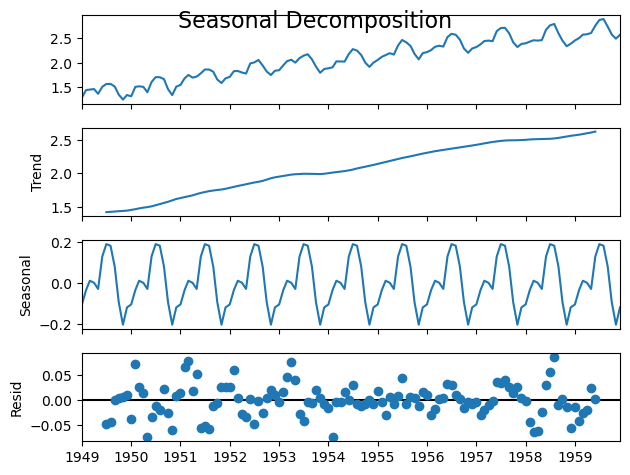

In [22]:
# Decompose the data into a trend and seasonal part
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train_log, model='additive', period=12)

trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

decomp.plot()
plt.suptitle("Seasonal Decomposition", fontsize=16)
plt.show()




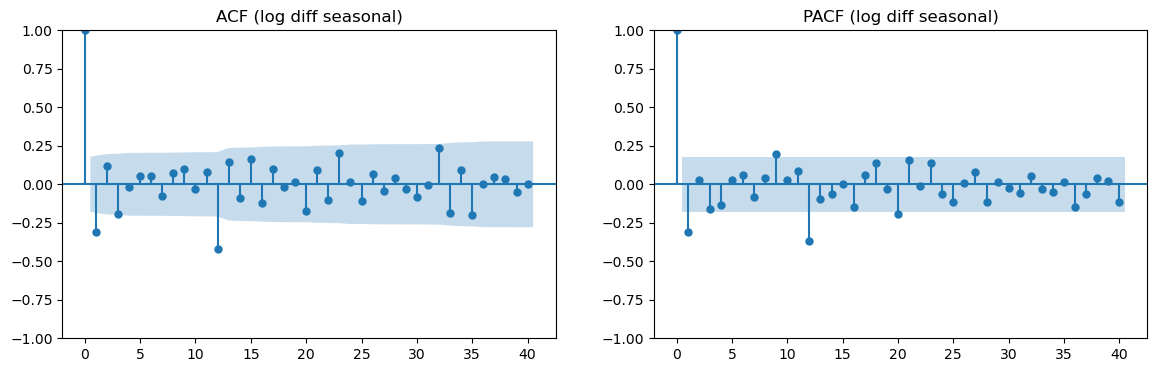

In [23]:
# ACF & PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

train_log_diff = train_log.diff(1).dropna()
train_log_diff_seasonal = train_log_diff.diff(12).dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train_log_diff_seasonal.dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF (log diff seasonal)")
plot_pacf(train_log_diff_seasonal.dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF (log diff seasonal)")
plt.show()



In [24]:
# Fit the SARIMA model
import pmdarima as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# SARIMA : seasonal=True et m=12 pour saison annuelle
sarima_model = pm.auto_arima(train_log,
                             start_p=0, start_q=0,
                             max_p=3, max_q=3,
                             d=1,              # différenciation non saisonnière
                             D=1,              # différenciation saisonnière
                             seasonal=True,
                             m=12,             # saison mensuelle (1 an)
                             trace=True,
                             stepwise=True,
                             suppress_warnings=True)




Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-434.600, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-406.734, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-443.351, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-447.095, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-416.233, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-445.761, Time=0.28 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-445.739, Time=0.55 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-443.833, Time=0.24 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-436.595, Time=0.17 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-445.024, Time=0.44 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-445.105, Time=0.34 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-447.012, Time=0.36 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-443.455, Time=0.75 sec
 ARIMA(0,1,1)(0,1,1)[12]

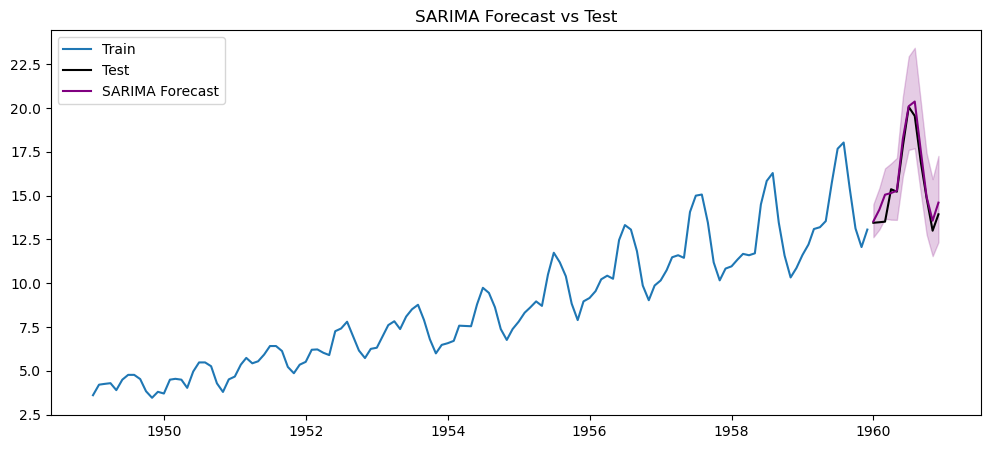

In [25]:
# Show train, test, predictions and confidence interval
n_periods = len(test_log)
forecast_log, conf_int_log = sarima_model.predict(n_periods=n_periods, return_conf_int=True)

# Re-transformer en échelle réelle
forecast = np.exp(forecast_log)
conf_int = np.exp(conf_int_log)

# Aligner avec l'index
forecast = pd.Series(forecast, index=test.index)

plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='black')
plt.plot(forecast, label='SARIMA Forecast', color='purple')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='purple', alpha=0.2)
plt.title("SARIMA Forecast vs Test")
plt.legend()
plt.show()




In [26]:
# Calculate the RMSE and the MAPE
from sklearn.metrics import mean_squared_error
# RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(test, forecast)

print("📊 SARIMA Performance on Test Set:")
print(f"✅ RMSE : {rmse:.2f}")
print(f"✅ MAPE : {mape:.2f}%")




📊 SARIMA Performance on Test Set:
✅ RMSE : 0.64
✅ MAPE : 3.27%


**Conclusions**
- What are your conclusions with respect to the previous ARIMA model ?

### 3.3 Auto-Arima  🎉

Auto ARIMA is an automated time series forecasting method that automatically selects the best combination of ARIMA model parameters ($p$, $d$, $q$) based on the data's characteristics. It uses algorithms to iteratively search and evaluate different models to find the most suitable one, saving users from manually tuning the parameters. Auto ARIMA is a powerful tool for efficiently forecasting time series data, especially when dealing with large datasets or when users have limited knowledge of time series modeling.

**TODO**
- Fit an `auto_arima` model and plot the diagnostics.
- How does it compare to the best model you found previously ?

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-441.880, Time=0.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-406.734, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-443.351, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-447.095, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-416.233, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-445.761, Time=0.32 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-445.739, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-443.833, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-436.595, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-445.024, Time=0.47 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-445.105, Time=0.31 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-447.012, Time=0.36 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-443.455, Time=1.03 sec
 ARIMA(0,1,1)(0,1,1)[12]

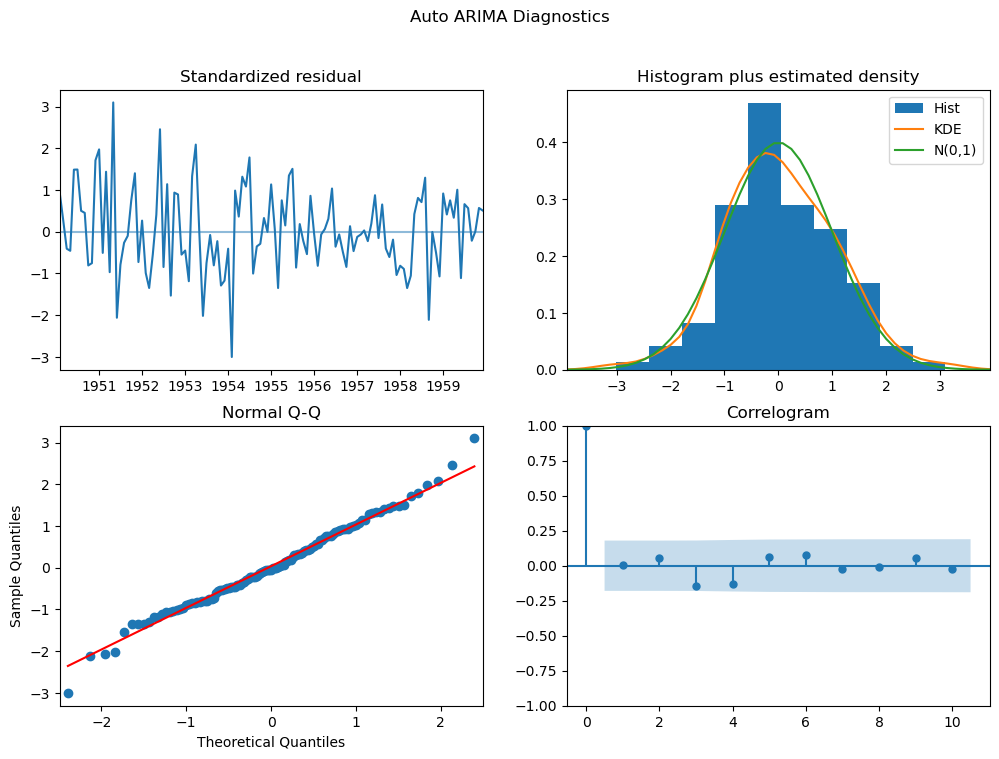

In [27]:
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

# Your code here
# Auto ARIMA avec saisonnalité (SARIMA auto)
auto_model = pm.auto_arima(train_log,
                           seasonal=True,
                           m=12,
                           d=1,       # différenciation ordinaire
                           D=1,       # différenciation saisonnière
                           stepwise=True,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True)

auto_model.plot_diagnostics(figsize=(12, 8))
plt.suptitle("Auto ARIMA Diagnostics")
plt.show()





In [28]:
# Prédictions test
n_periods = len(test)
forecast_log_auto, confint_log_auto = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Retour à l’échelle réelle
forecast_auto = np.exp(forecast_log_auto)
confint_auto = np.exp(confint_log_auto)

# Évaluation
rmse_auto = np.sqrt(mean_squared_error(test, forecast_auto))
mape_auto = mean_absolute_percentage_error(test, forecast_auto)

print("📊 Auto ARIMA Performance:")
print(f"✅ RMSE : {rmse_auto:.2f}")
print(f"✅ MAPE : {mape_auto:.2f}%")


📊 Auto ARIMA Performance:
✅ RMSE : 0.64
✅ MAPE : 3.27%


**Conclusions**
- How does `auto_arima` perform with respect to your previous models ? Can you explain why ?

# 4. Cross-Validation

As you know, cross-validation is a crucial technique in the context of machine learning, designed to assess the predictive performance of these models and mitigate potential pitfalls associated with using limited data. Unlike traditional cross-validation used in other machine learning applications, time series cross-validation takes into account the temporal order of the data, ensuring that does not have any information from the future that it would not otherwise have at the time of making a forecast. 
By dividing the time series data into multiple subsets and iteratively validating the model's performance against unseen data, cross-validation provides valuable insights into how well the ARIMA model generalizes to different time periods. This rigorous evaluation will allow you to fine-tune model hyperparameters (such as ARIMA's parameters), assess forecast accuracy, and build more robust and reliable time series forecasting models.

In the classicial time series literature, time series cross validation is called a **Rolling Forecasting Horizon**. This is explained in details [here](https://robjhyndman.com/hyndsight/tscv/)

In [29]:
from forecast.model_selection import time_series_cv

split_date = airline.index[int(len(airline) * 0.8)]


**TODO**
- Split the train data into a train and validation sets

In [30]:
# I've written a function to help with the cv of the baseline model
# THIS FUNCTION IS LOCATED IN THE ./forecast DIRECTORY, ALONG WITH THE NOTEBOOK

from forecast.model_selection import time_series_cv
import numpy as np
from sktime.forecasting.base import ForecastingHorizon


def time_series_cv(model, error_func, train, val, horizons, step=1):
    '''
    Time series cross validation across multiple horizons for a single model.

    Incrementally adds additional training data to the model and tests
    across a provided list of forecast horizons. Note that function tests a
    model only against complete validation sets.  E.g. if horizon = 15 and 
    len(val) = 12 then no testing is done.  In the case of multiple horizons
    e.g. [7, 14, 28] then the function will use the maximum forecast horizon
    to calculate the number of iterations i.e if len(val) = 365 and step = 1
    then no. iterations = len(val) - max(horizon) = 365 - 28 = 337.
    
    Parameters:
    --------
    model - forecasting model

    error_func - function to measure forecast error

    train - np.array - vector of training data

    val - np.array - vector of validation data

    horizon - list of ints, forecast horizon e.g. [7, 14, 28] days

    step -- step taken in cross validation 
            e.g. 1 in next cross validation training data includes next point 
            from the validation set.
            e.g. 7 in the next cross validation training data includes next 7 points
            (default=1)
            
    Returns:
    -------
    np.array - vector of forecast errors from the CVs.
    '''
    cvs = []

    #change here: max(horizons) + 1
    for i in range(0, len(val) - max(horizons) + 1, step):
        
        train_cv = np.concatenate([train, val[:i]], axis=0)
        model.fit(train_cv)
        
        #predict the maximum horizon
        try:
            preds = model.predict(horizon=len(val[i:i+max(horizons)]))
        # hack to work with sktime Naive Forecasters
        except:
            fh = ForecastingHorizon(list(range(1, max(horizons)+1)), is_relative=True)
            preds = model.predict(fh=fh)
            preds = preds.flatten()
            #preds = model.predict(fh=len(val[i:i+max(horizons)]))
            
        horizon_errors = []
        for h in horizons:
            #would be useful to return multiple prediction errors in one go.
            pred_error = error_func(preds[:h], val[i:i+h])
            horizon_errors.append(pred_error)
        
        cvs.append(horizon_errors)
    
    return np.array(cvs)

# It requires the data to be split into train and validation

# Split the data into train and validation sets
split_date = airline.index[int(len(airline) * 0.8)]
train, val = ts_train_test_split(airline, split_date)

time_series_cv(
    model=seasonal_naive_forecaster,
    error_func=mean_absolute_percentage_error,
    train=train,
    val=val,
    horizons=[7, 14, 28],  # Example horizons
    step=1  # Step size for cross-validation
)

# Print the sizes to see if it's all good
print("Training set size:", len(train))
print("Validation set size:", len(val))


Training set size: 115
Validation set size: 29


### 4.1 Cross-Validation with Naive model

**TODO**
- Perform a cross-validation with the Seasonal Naive model you built previously

In [31]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

HORIZON = 12  # We plan to make forecasts for the following 12 months
PERIOD = 12  # Expected period of seasonality

# Define the length of time into the future for which forecasts are to be prepared
fh = ForecastingHorizon(test.index, is_relative=False)

In [32]:
print(airline.index)

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')


In [33]:
# Define the model
seasonal_naive_forecaster = NaiveForecaster(strategy="last", sp=PERIOD)  # sp = saisonnalité


# Call time_series_cv
cv_results = time_series_cv(
    model = seasonal_naive_forecaster,
    error_func = mean_absolute_percentage_error,
    train = train.to_numpy(),
    val = val.to_numpy(),
    horizons = [6, 12, 24],
    step = 1  # Step size for cross-validation
)

# Show results
print("Cross-validation results:")
print(cv_results)


Cross-validation results:
[[ 3.23576241  7.3938943  14.71094434]
 [ 3.13744989  7.60689633 14.82993643]
 [ 5.16323258  8.82389303 15.90254369]
 [ 6.88571427  9.64991472 16.77893745]
 [ 9.22957012 10.91115216 17.70613646]
 [10.59759147 12.56785404 18.85341226]]


### 4.2 Cross-Validation with ARIMA

**TODO**
- Perform a cross-validation with your best ARIMA model. 
- Try different step values in the RollingForecastCV. What's the difference ?
- In each case, what's the size of the the data the model is trained on ?
- How many splits did we get ?

In [34]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

# Manually create the arima model
best_arima = ARIMA(order=(1,1,1), seasonal_order=(0,1,1,12))  

# Create a RollingForecastCV instance
cv = RollingForecastCV(h=12, step=1, initial=100)


# Call cross_val_score
scores = cross_val_score(best_arima, airline, cv=cv, scoring='smape')
print("MAPE scores for each fold:")
print(scores)
print("Mean MAPE:", scores.mean())

MAPE scores for each fold:
[ 4.71357866  5.43991808  7.57947165  8.90384961 11.33331414  9.29050869
  6.70124399  5.80726636  5.31714974  4.44769245  2.78259269  3.07758833
  4.89622244  4.6391943   4.1302902   4.32193245  5.0662823   6.7623216
  7.04012844  8.38376607 11.32557421  7.71688053  6.45539129  2.97548008
  2.34165916  2.19138025  3.6779893   2.10579079  2.32578363  2.53210229
  2.23303102  2.72594964  4.28821806]
Mean MAPE: 5.2584709827770375


# 5. The Final Forecast

In [35]:
# Define the model
seasonal_naive_forecaster = NaiveForecaster(strategy="last", sp=PERIOD)  # sp = saisonnalité


# Call time_series_cv
cv_results = time_series_cv(
    model = seasonal_naive_forecaster,
    error_func = mean_absolute_percentage_error,
    train = train.to_numpy(),
    val = val.to_numpy(),
    horizons = [6, 12, 24],
    step = 1  # Step size for cross-validation
)

# Show results
print("Cross-validation results:")
print(cv_results)


Cross-validation results:
[[ 3.23576241  7.3938943  14.71094434]
 [ 3.13744989  7.60689633 14.82993643]
 [ 5.16323258  8.82389303 15.90254369]
 [ 6.88571427  9.64991472 16.77893745]
 [ 9.22957012 10.91115216 17.70613646]
 [10.59759147 12.56785404 18.85341226]]


**TODO**
- Following the same methodology as above, produce your final forecast with your best model!
- Plot the predictions of the **Naive**, **Seasonal Naive**, and your best **SARIMA** model along with the test data, and compare they performances!

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-441.880, Time=0.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-406.734, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-443.351, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-447.095, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-416.233, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-445.761, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-445.739, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-443.833, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-436.595, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-445.024, Time=0.49 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-445.105, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-447.012, Time=0.30 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-443.455, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12]

<Figure size 1200x500 with 0 Axes>

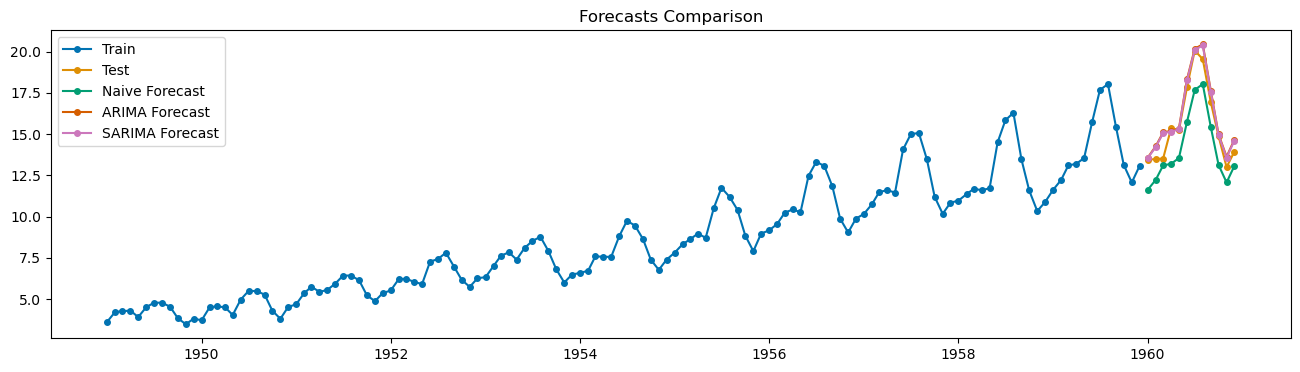

In [36]:
# Your code here
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from pmdarima.utils import acf, pacf
from pmdarima import ARIMA

airline = load_airline().dropna()
airline = airline / airline.index.days_in_month
train, test = ts_train_test_split(airline, '1960-01-01')
train_log = np.log(train).dropna()

HORIZON = 12  # We plan to make forecasts for the following 12 months
PERIOD = 12  # Expected period of seasonality


# Define models
naive = NaiveForecaster(strategy="last", sp = PERIOD)
naive.fit(train)

arima = ARIMA(order=(1,1,1), seasonal_order=(0,1,1,12))
arima.fit(train_log)

sarima = auto_arima(
    train_log,
    seasonal=True,
    m=PERIOD,
    d=1,       # différenciation ordinaire
    D=1,       # différenciation saisonnière
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
sarima.fit(train_log)


# Fit models


# Create predictions
naive_preds = naive.predict(ForecastingHorizon(test.index, is_relative=False))
arima_preds = np.exp(arima.predict(n_periods=len(test)))
sarima_preds = np.exp(sarima.predict(n_periods=len(test)))


# Plot predictions
plt.figure(figsize=(12, 5))
plot_series(train, test, naive_preds, arima_preds, sarima_preds,
            labels=["Train", "Test", "Naive Forecast", "ARIMA Forecast", "SARIMA Forecast"])
plt.title("Forecasts Comparison")
plt.show()


# Bonus

### B1. Write a class with the following methods:
* The necessary arguments to split the dataset, fit the auto_arima model etc.
* A `fit` method which fits the auto_arima naive using a train dataset
* A `get_metrics` method which computes the MAPE for each models using a test dataset
* A `predict` method which takes as input a prediction horizon and returns predicted values.
* A `plot` method which plots the data, and if available the predictions 

**Have some time left ?** 
* Add a method `get_cv` Which performs cross validation
* To further automatize the process, add an automatic detection of the period.
* Add the possibility to apply a preprocessing of the data before the fit such as a log transformation.

In [37]:
# Write your class here




### B2. Test this method on all the other [11 datasets] of pmdarima

https://alkaline-ml.com/pmdarima/modules/classes.html#module-pmdarima.datasets
To help you, we provide the list of dataset names and a function to load any of these datasets.

On some of them the method does not work well, why? What could be done to improve it?

In [38]:
dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']

def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pm.datasets, 'load_'+ds_name)(as_series=True).dropna()
    
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    
    return ds.dropna()

### B3. Want some more ?

Choose your poison: https://data.world/datasets/time-series